In [4]:
pip install pandas numpy matplotlib seaborn statsmodels scikit-learn xgboost folium geopandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Infinity M10\AppData\Local\Temp\ipykernel_29660\1920198168.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)


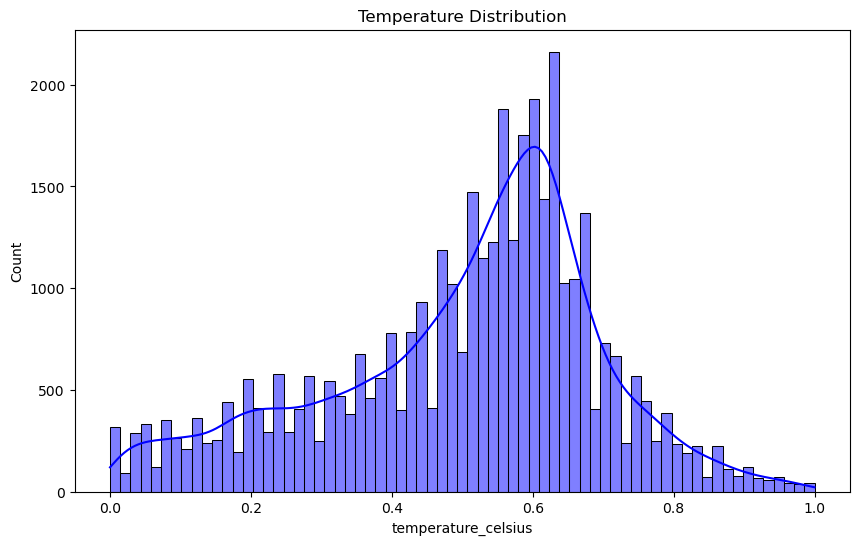

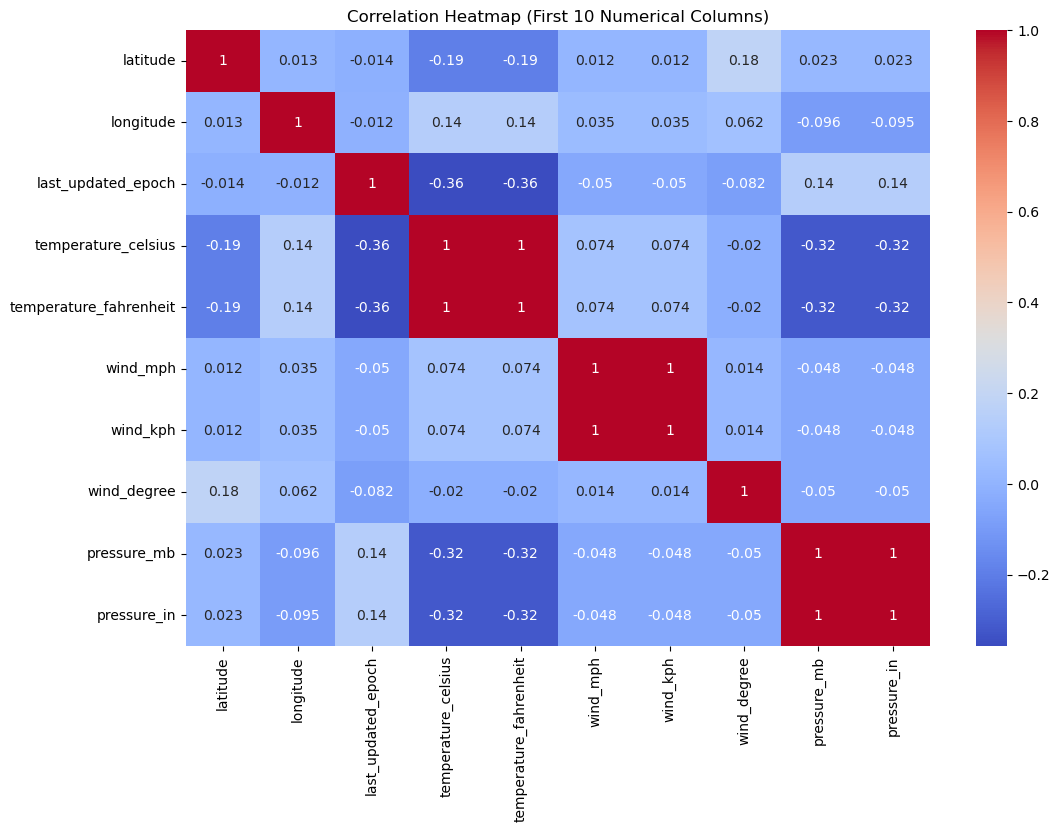

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-

ARIMA Forecast: 39064    0.381586
39065    0.354767
39066    0.411244
39067    0.399069
39068    0.411835
39069    0.404441
39070    0.393521
39071    0.394086
39072    0.402432
39073    0.401275
Name: predicted_mean, dtype: float64
Random Forest Model:
R-squared: 0.6438097782239218
MAE: 0.07914872992168548

XGBoost Model:
R-squared: 0.674067935379974
MAE: 0.07884101322309223


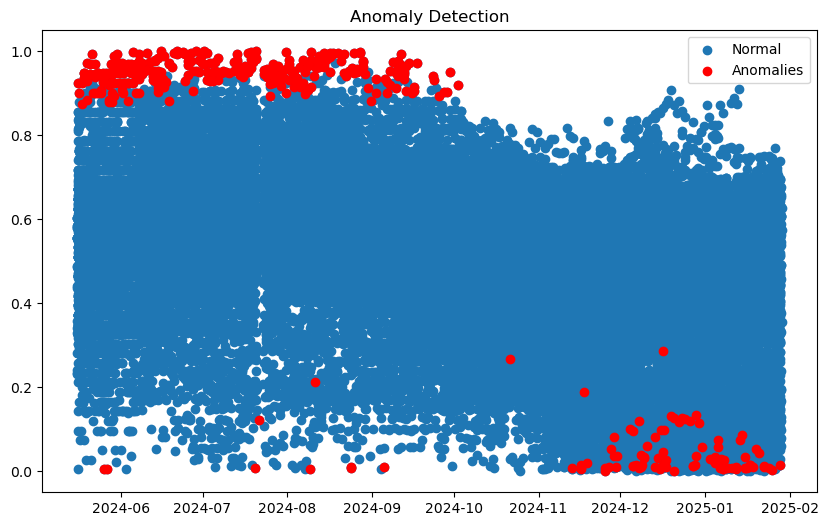

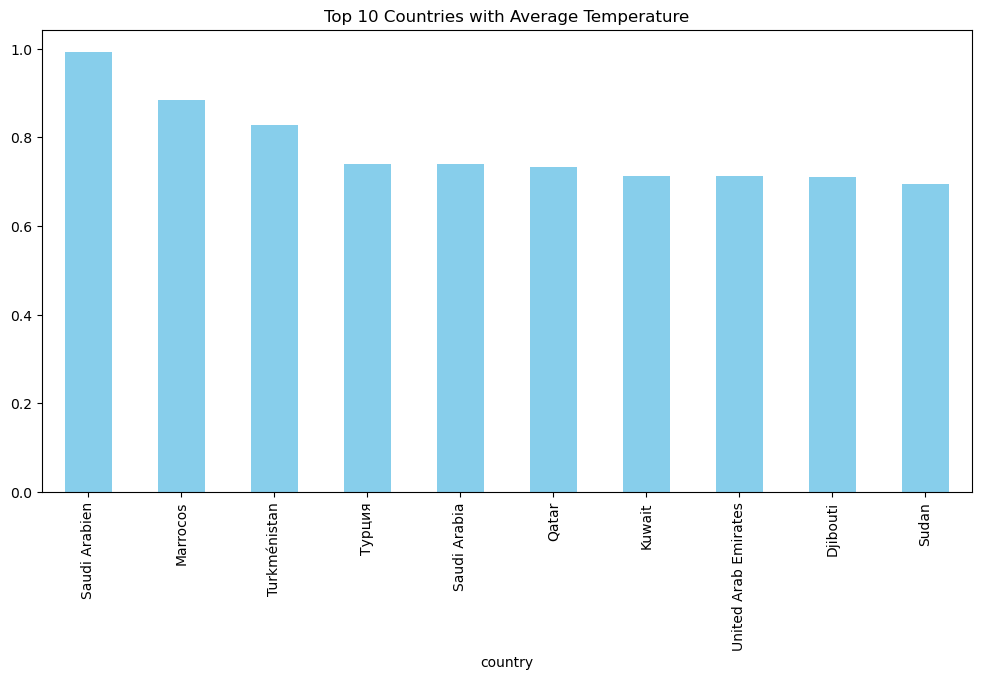

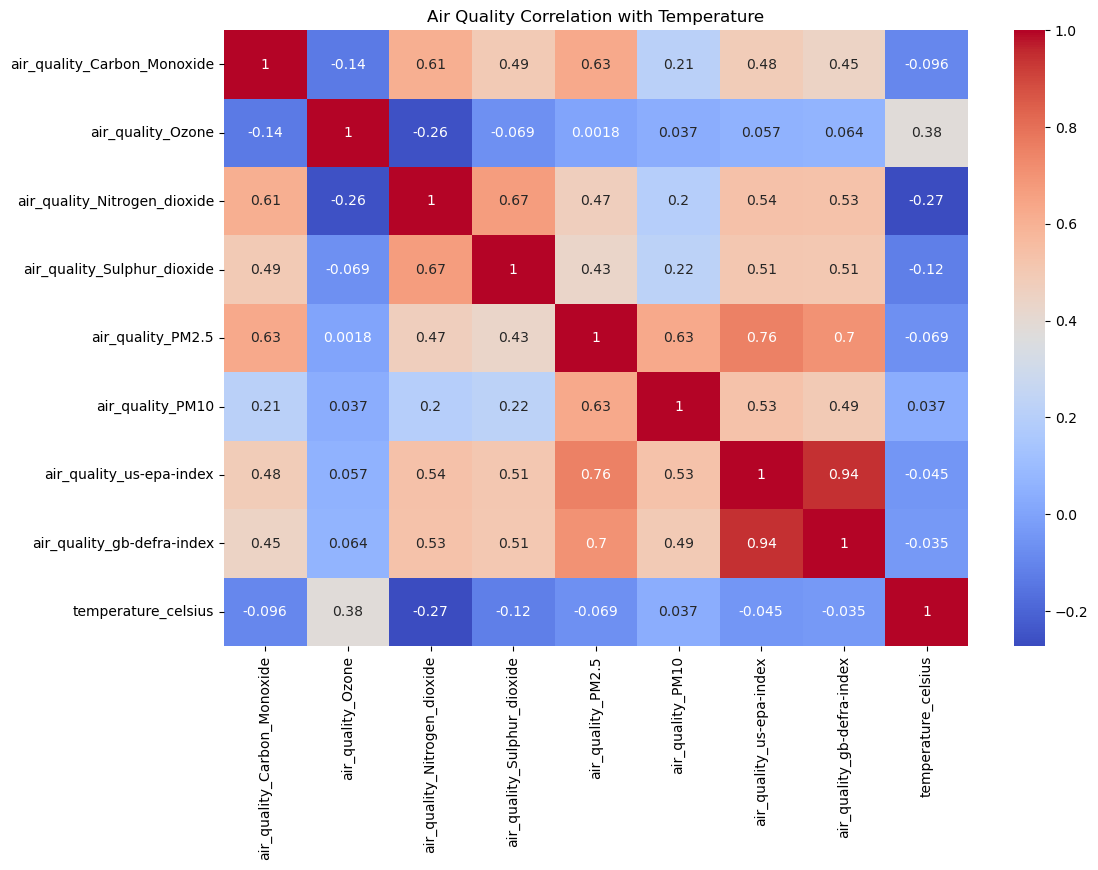

Interactive heatmap saved at: temperature_heatmap.html


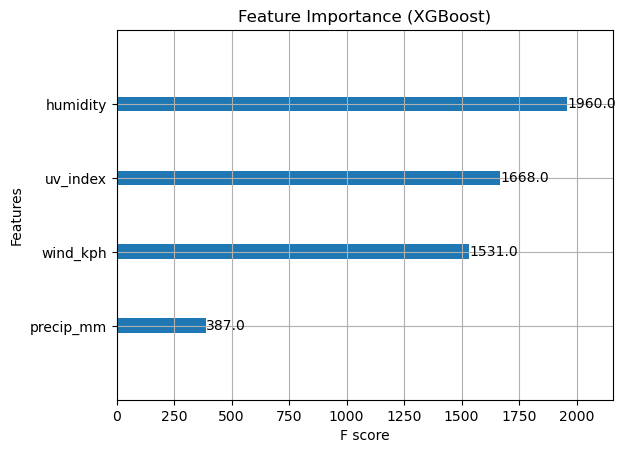

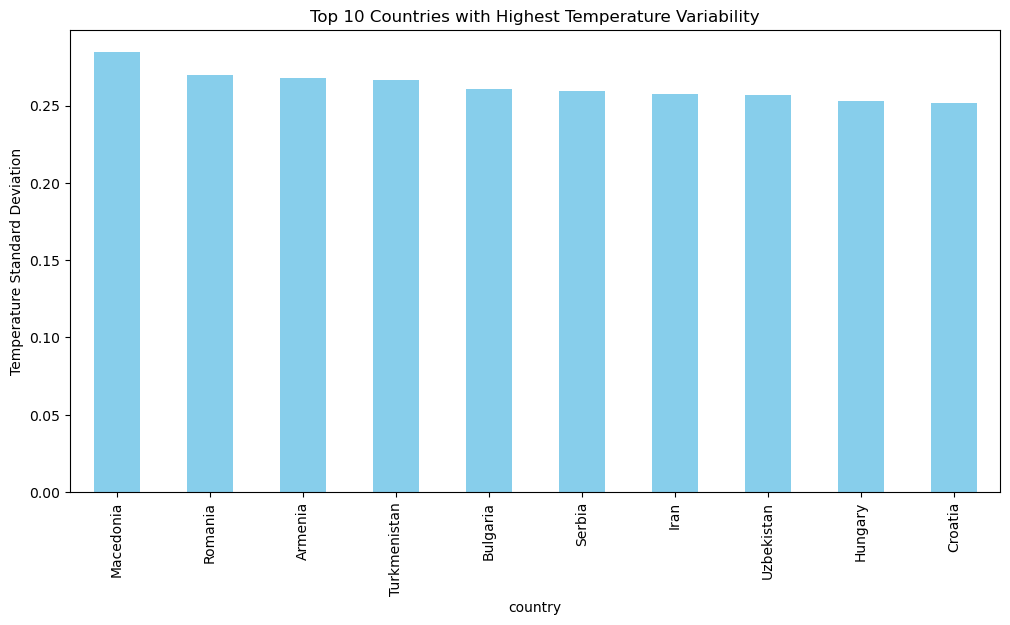

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import IsolationForest
import folium
from folium.plugins import HeatMap
from statsmodels.tsa.arima.model import ARIMA

# Load dataset
weather_data = pd.read_csv('compressed_data.csv')

# Step 1: Data Cleaning
# Handle missing values
weather_data.fillna(method='ffill', inplace=True)

# Handle outliers (e.g., using IQR method for selected columns)
for column in ['temperature_celsius', 'humidity', 'precip_mm']:
    Q1 = weather_data[column].quantile(0.25)
    Q3 = weather_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    weather_data = weather_data[(weather_data[column] >= lower_bound) & (weather_data[column] <= upper_bound)]

# Normalize numerical data
scaler = MinMaxScaler()
weather_data[['temperature_celsius', 'humidity']] = scaler.fit_transform(weather_data[['temperature_celsius', 'humidity']])

# Step 2: EDA
# Plot temperature distribution
plt.figure(figsize=(10, 6))
sns.histplot(weather_data['temperature_celsius'], kde=True, color='blue')
plt.title('Temperature Distribution')
plt.show()

# Select only the first 10 numerical columns for the correlation heatmap
numeric_data = weather_data.select_dtypes(include=['float64', 'int64']).iloc[:, :10]

# Calculate and plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (First 10 Numerical Columns)')
plt.show()


# Step 3: Forecasting with ARIMA
weather_data['last_updated'] = pd.to_datetime(weather_data['last_updated'])
weather_data.set_index('last_updated', inplace=True)

# Basic ARIMA model for temperature forecasting
model = ARIMA(weather_data['temperature_celsius'].dropna(), order=(5, 1, 0))
model_fit = model.fit()

# Forecast next 10 steps
forecast = model_fit.forecast(steps=10)
print("ARIMA Forecast:", forecast)
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate R-squared and MAE for Random Forest
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

# Calculate R-squared and MAE for XGBoost
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

# Print the results
print(f"Random Forest Model:")
print(f"R-squared: {rf_r2}")
print(f"MAE: {rf_mae}")

print(f"\nXGBoost Model:")
print(f"R-squared: {xgb_r2}")
print(f"MAE: {xgb_mae}")


# Step 4: Anomaly Detection using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
weather_data['anomaly'] = iso.fit_predict(weather_data[['temperature_celsius', 'humidity']])

# Visualize anomalies
anomalies = weather_data[weather_data['anomaly'] == -1]
plt.figure(figsize=(10, 6))
plt.scatter(weather_data.index, weather_data['temperature_celsius'], label='Normal')
plt.scatter(anomalies.index, anomalies['temperature_celsius'], color='red', label='Anomalies')
plt.legend()
plt.title('Anomaly Detection')
plt.show()

# Step 5: Advanced Forecasting with Random Forest and XGBoost
X = weather_data[['humidity', 'precip_mm', 'wind_kph', 'uv_index']]
y = weather_data['temperature_celsius']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Step 6: Climate Analysis by Country
# Group by country and calculate average temperature
climate_data = weather_data.groupby('country')['temperature_celsius'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
climate_data.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries with Average Temperature')
plt.show()

# Step 7: Environmental Impact Analysis - Correlation with Air Quality
air_quality_columns = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
                       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 
                       'air_quality_us-epa-index', 'air_quality_gb-defra-index']

# Correlation with temperature and other weather variables
air_quality_corr = weather_data[air_quality_columns + ['temperature_celsius']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(air_quality_corr, annot=True, cmap='coolwarm')
plt.title('Air Quality Correlation with Temperature')
plt.show()

# Step 8: Spatial Analysis: Visualize Temperature Heatmap
spatial_data = weather_data[['latitude', 'longitude', 'temperature_celsius']]

# Create map centered on the average location
m = folium.Map(location=[spatial_data['latitude'].mean(), spatial_data['longitude'].mean()], zoom_start=2)

# Add temperature data as a heatmap
heatmap_data = spatial_data[['latitude', 'longitude', 'temperature_celsius']].dropna()
HeatMap(data=heatmap_data.values, radius=10, blur=15, max_zoom=1).add_to(m)

# Save the map for visualization
map_path = 'temperature_heatmap.html'
m.save(map_path)
print(f"Interactive heatmap saved at: {map_path}")

# Step 9: Feature Importance (XGBoost)
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

# Step 10: Geographical Variability by Country
# Group by country and analyze temperature variability (mean and std)
country_variability = weather_data.groupby('country').agg({'temperature_celsius': ['mean', 'std']})

# Sort by standard deviation (temperature variability) and take the top 10
top_10_country_variability = country_variability['temperature_celsius']['std'].sort_values(ascending=False).head(10)

# Plot the top 10 countries with the highest temperature variability
top_10_country_variability.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Top 10 Countries with Highest Temperature Variability')
plt.ylabel('Temperature Standard Deviation')
plt.show()

